#  Masking Pipeline


"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [208]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [209]:
#hdr = db[{{ uid }}]

In [245]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



In [246]:
from eiger_io.pims_reader import EigerImages as Images

In [221]:
%matplotlib notebook

In [222]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/


/XF11ID/analysis/Analysis_Pipelines/Develop


In [236]:
cd /home/yuzhang/chx-pipelines/Develops/

/home/yuzhang/chx-pipelines/Develops


In [237]:
%run develop.py
%run two_time.py

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [259]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

In [342]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    uid='ec41569e'  #a gisaxs example,
    uid='71720966' 
    uid = 'ffe9d518'  # 10 mTorr 1sec/frame
    
    
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5'   

## Get data from the uid

In [343]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)
    


hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## Get data path

In [344]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/11/8/'

# Load ManuMaks or Not

In [345]:
load_ManuMask = False
ManuMask =  None

## show the pixel mask

<IPython.core.display.Javascript object>


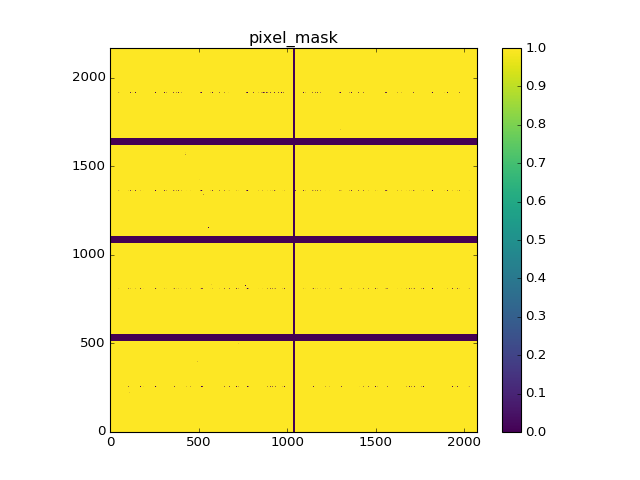

In [346]:
fig, ax = plt.subplots()
im = ax.imshow(imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis',origin='lower')
ax.set_title( 'pixel_mask')
fig.colorbar( im )
plt.show()

# show one image with pixel_mask

<IPython.core.display.Javascript object>


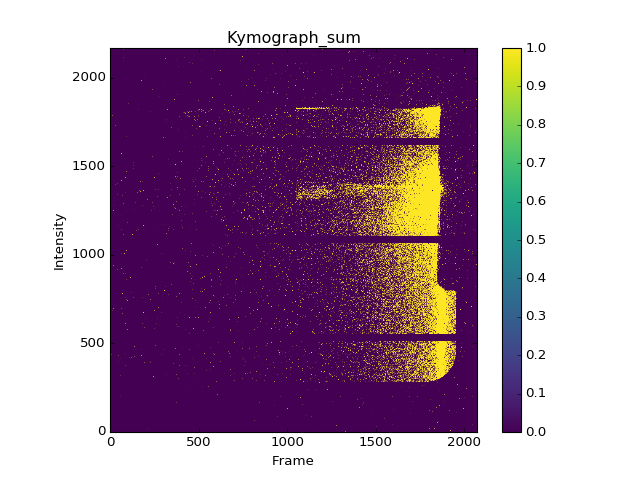

In [347]:
fig, ax = plt.subplots()
im = ax.imshow(imgs[0]*imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis',origin='lower')
ax.set_title( 'imgs_0')
fig.colorbar( im )


# Check bad images by waterfall plot

In [348]:
masker =Masker( imgs, imgs.md['pixel_mask'])

In [349]:
#one option: sum of each frame intensity, this code is slow
#bin_img = 1
#imgsum = [np.sum(img* mask) for img in imgs[::bin_img ]]


In [350]:
imgs.shape

(2167, 2070)

### Users put interested retangle here

In [351]:
rectangle = [ [0, 1500, 2050, 1], ]  # corner y, x, length, width

In [352]:
roi_data = np.array((  rectangle ), dtype=np.int64)  
rect_array = roi.rectangles(roi_data, shape=imgs.shape) * imgs.md['pixel_mask']

<IPython.core.display.Javascript object>


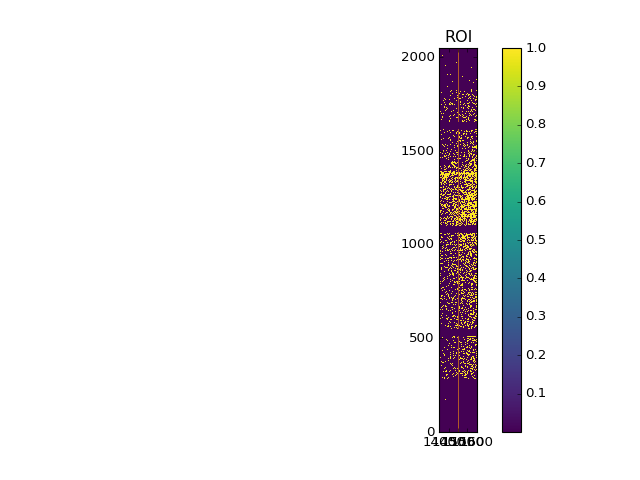

In [353]:
fig, axes = plt.subplots( )
axes.set_title("ROI")
im,im_label = show_label_array_on_image(axes, masker[0], rect_array, imshow_cmap='viridis', 
                cmap='Paired',    vmin=0.0001, vmax= 1, log_img=False, origin="lower")
#im = axes.imshow(rect_array, norm=LogNorm(0.001,1.0),cmap='viridis',origin='lower')

axes.set_xlim(  rectangle[0][1] -100, rectangle[0][1] +100  )
axes.set_ylim(  rectangle[0][0] -0, rectangle[0][0] + rectangle[0][2] )

fig.colorbar(im )
plt.show()

In [354]:
qind, pixelist = roi.extract_label_indices(   rect_array  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:]  

In [355]:
t0 = time.time()
data_pixel =   Get_Pixel_Array( imgs, pixelist).get_data()
mean_inten = get_mean_intensity( data_pixel, qind)

run_time(t0)

Total time: 5.04 min


In [356]:
bad_frame = np.where( mean_inten[1] == mean_inten[1].max())[0]
print ('The bad frame number is:  %s'%bad_frame)

The bad frame number is:  [1245]


<IPython.core.display.Javascript object>


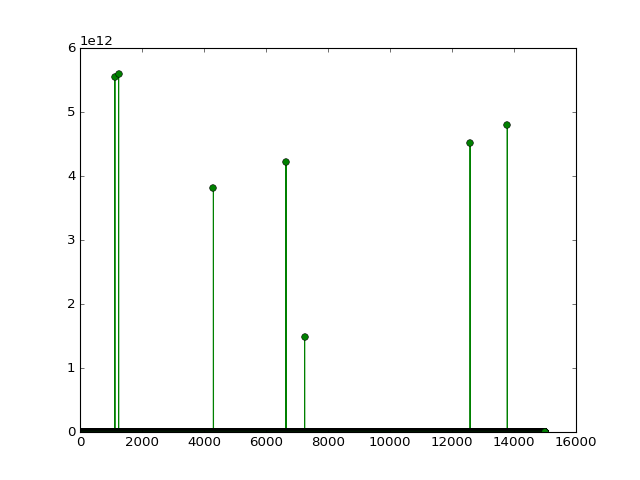

In [357]:
 
fig, axes = plt.subplots(  )
axes.plot( mean_inten[1], '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Show waterfall

In [358]:
if False:
    fig, ax = plt.subplots( )
    ax.set_ylabel('Pixel')
    ax.set_xlabel('Frame')
    ax.set_title('Kymograph')
    ax.imshow(kymo.T, cmap='viridis', vmin=0.0001, vmax= 1, aspect=6.0)
    
    plt.show() 

## save the kymo_sum

In [359]:
np.save( path +  str(uid)+"_kymo_sum",mean_inten[1] ) 
data_pixel=[]

## Remove hotspots in the image

In [360]:
hot= np.array([imgs[i].max() for i in np.random.random_integers(0, 200-1, 5)]).mean()

In [361]:
hot

4294967295.0

In [362]:
mask_rh  = RemoveHotSpots( masker, hot)._get_mask(Ns=0,Ne=10)

In [363]:
makser = Masker( imgs, imgs.md['pixel_mask']*mask_rh)

<IPython.core.display.Javascript object>


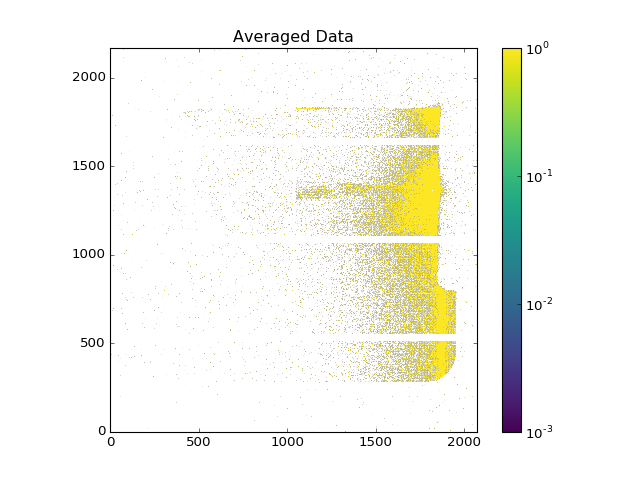

In [383]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(makser[0],  cmap='viridis',origin='lower', 
              norm= LogNorm( vmin=0.001, vmax=1 ) )

fig.colorbar(im)
ax.set_title("Remove_hot_pixel")
plt.show()

In [365]:
(imgs[100]*imgs.md['pixel_mask']).max()

4294967295

In [366]:
(imgs[100]*imgs.md['pixel_mask'] *  mask_rh ).max()

14487

## Import all the required packages to create manual mask
xray-vision - plotting helper functions for X-ray science
https://github.com/Nikea/xray-vision

In [367]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

## Get the Averaged Image Data

In [368]:
good_start = 0
good_end= 7600

avg_img = np.average(imgs[good_start:good_end: 10], axis=0) #*imgs.md['pixel_mask']  #*mask_rh


In [369]:
avg_img =avg_img*imgs.md['pixel_mask']*mask_rh

<IPython.core.display.Javascript object>


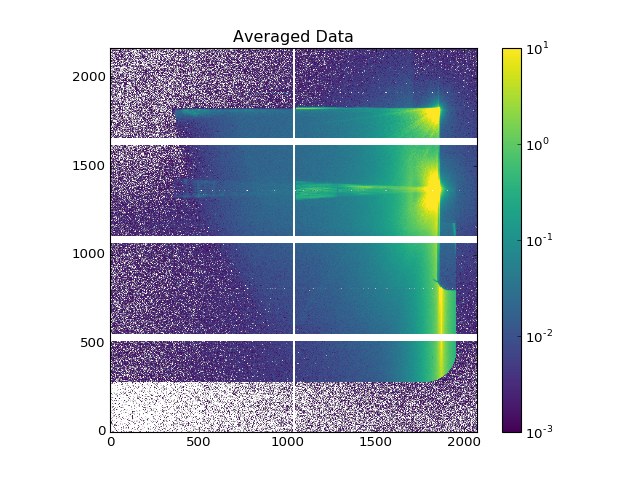

In [370]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img,  cmap='viridis',origin='lower', 
              norm= LogNorm( vmin=0.001, vmax=1e1 ) )

fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

# save ave_img data

In [371]:
np.save( path +  str(uid)+"_avg_img",avg_img ) 

## Create the mask file
More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

<IPython.core.display.Javascript object>


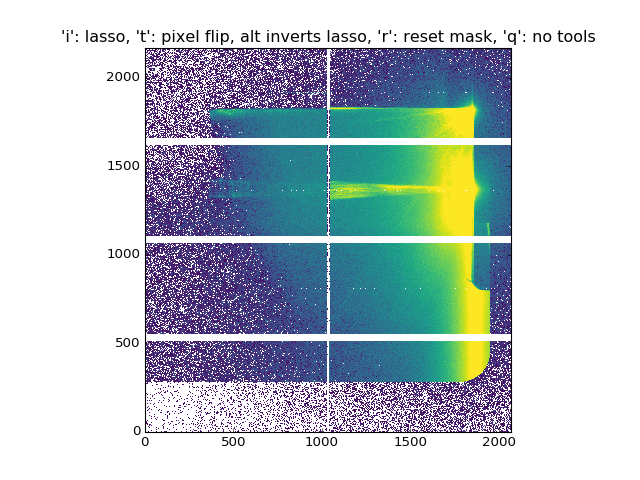

In [372]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e0 ) )
plt.show()

In [373]:
#np.save( new_path + 'mask_SiO2',m.mask)

In [374]:
if load_ManuMask:
    
    new_mask = np.load( new_path +'mask_SiO2.npy' )
    
else:
    new_mask = m.mask
    
    

<IPython.core.display.Javascript object>


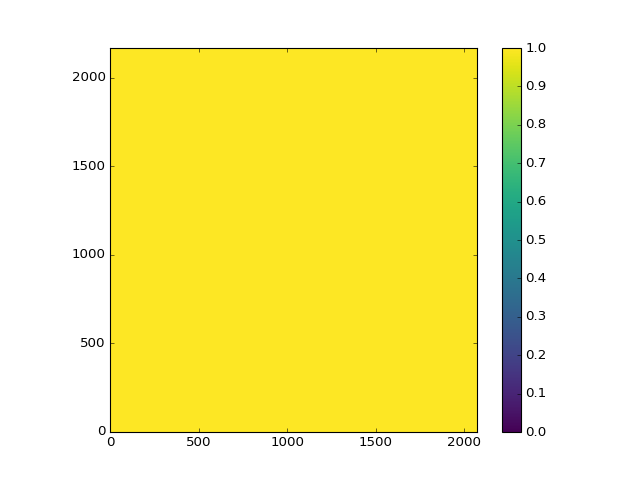

In [375]:

fig, ax = plt.subplots()
im=ax.imshow(~new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Combine the hand-drawn mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


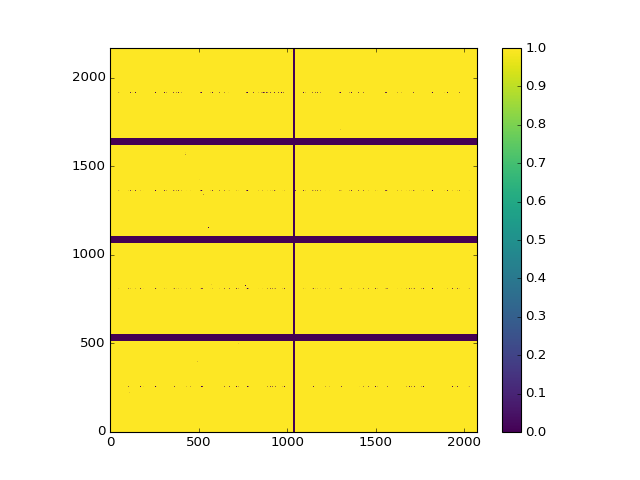

In [376]:
mask = (~new_mask)*imgs.md['pixel_mask']*mask_rh

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## save the combined mask to use in data analysis

In [377]:
np.save(path + str(uid)+"_mask", mask )